## Liquid helium Notebook
------
To run on NERSC:

module load python

source activate lims-test


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import darklim

from multihist import Hist1d

%matplotlib inline

1-fold coincidence:
integral from 0.0001 to 0.5 keV = 4.13e+04 evts/day
= 4.78e-01 evts/s
 
2-fold coincidence:
integral from 0.0001 to 0.5 keV = 1.49e+00 evts/day
= 1.73e-05 evts/s
 
3-fold coincidence:
integral from 0.0001 to 0.5 keV = 3.58e-05 evts/day
= 4.15e-10 evts/s
 
4-fold coincidence:
integral from 0.0001 to 0.5 keV = 4.30e-10 evts/day
= 4.98e-15 evts/s
 


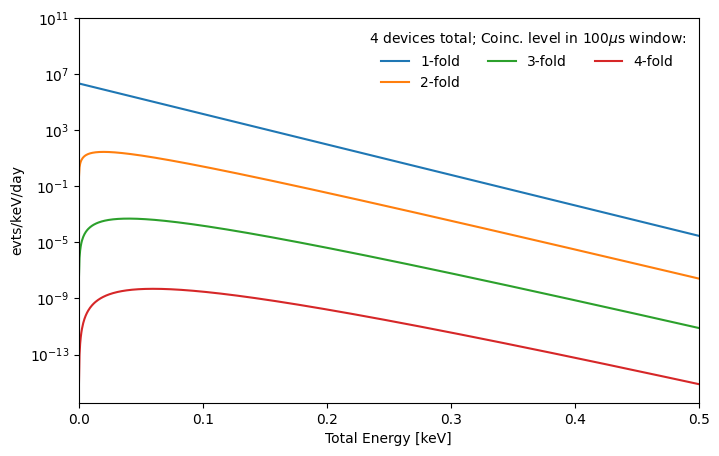

In [2]:
# test the nfold LEE function

fig, ax = plt.subplots(1,figsize=(6,4))

bins = np.linspace(0.0001,0.5,1000)

n_devices = 4
coinc = np.arange(1,5)
window = 100e-6# s
for n in coinc:
    
    print('{}-fold coincidence:'.format(n))
    model = darklim.sensitivity.n_fold_lee(bins,m=n_devices,n=n,w=window)
    
    integral = np.trapz(model,x=bins)
    print('integral from {} to {} keV = {:.2e} evts/day'.format(bins[0],bins[-1],integral))
    print('= {:0.2e} evts/s'.format(integral/24/3600))
    print(' ')
    
    plt.plot(bins,model,label='{:d}-fold'.format(n))

#lhe_mass = 0.010 # kg
#ax.axhline(1*lhe_mass,label='1 DRU in 10g LHe'.format(n),color='black',ls='--') # 1 DRU=1 evt/keV/d/kg
#plt.plot(bins,
    
ax.set_ylabel('evts/keV/day')
ax.set_xlabel('Total Energy [keV]')
ax.set_xlim(0,0.5)
ax.set_yscale('log')
ax.set_ylim(None,1e11)
ax.legend(loc='upper right',frameon=False,title='{:d} devices total;'.format(n_devices)+' Coinc. level in {:0.0f}'.format(window*1e6)+r'$\mu$s window:',ncol=3)

In [4]:
# Detector info setup

time_elapsed = 100 # days
efficiency = 1.0
tm = 'He' # target name
mass_det = 0.010 # mass in kg
energy_res = 0.373e-3 # energy resolution in keV
threshold = 5 * energy_res # threshold

n_devices = 4
coinc = 2
window = 100e-6 # s

print('detector mass is {} kg = {} g'.format(mass_det,mass_det*1000))
print('threshold = {:0.1f} eV'.format(threshold*1000))
print('assuming {:d}-fold coincidence amongst {:d} devices in a {:0.1f} microsecond window'.format(coinc,n_devices,window/1e-6))



detector mass is 0.01 kg = 10.0 g
threshold = 1.9 eV
assuming 2-fold coincidence amongst 4 devices in a 100.0 microsecond window


In [5]:
def smeared_wimp(en_interp,mass,sigma0=1e-41,tm='He',res=None):
    init_rate = darklim.limit.drde(en_interp, mass, sigma0, tm=tm)
    if res is not None:
        init_rate = darklim.limit.gauss_smear(en_interp, init_rate, res)
    return init_rate

expect 4255.0 evts
created 4233.0 evts


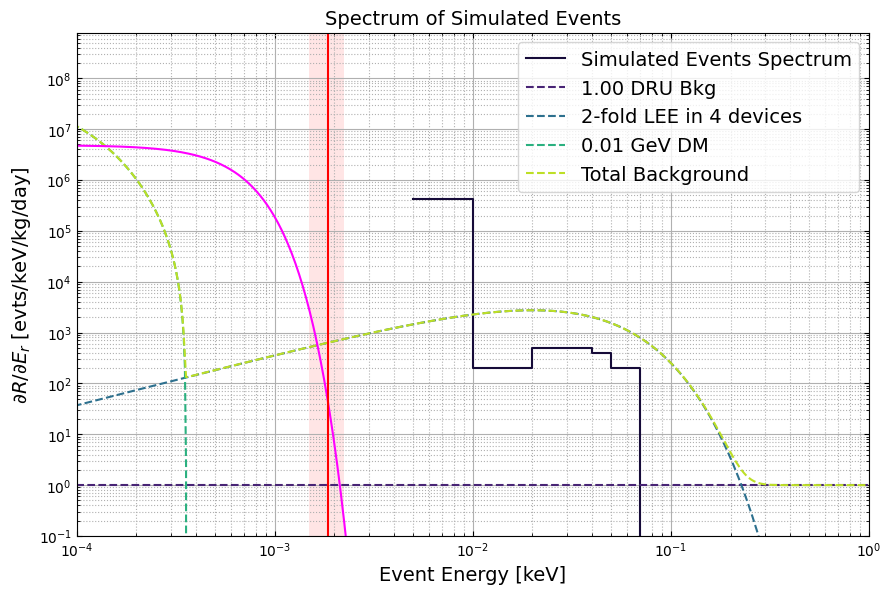

In [6]:
SE = darklim.sensitivity.SensEst(mass_det, time_elapsed, eff=efficiency, tm=tm)

SE.reset_sim()
SE.add_flat_bkgd(1) # flat background of 1 DRU
#SE.add_nfold_lee_bkgd(m=4,n=2,w=window)
SE.add_nfold_lee_bkgd(m=n_devices,n=coinc,w=window)

dmmass = 0.01
xsec = 2e-38

SE.add_dm_bkgd(dmmass, xsec)

en_interp = np.geomspace(1e-6,1, num=1000)
dm = smeared_wimp(en_interp,dmmass,sigma0=xsec,tm=tm,res=energy_res)

gen_evts = SE.generate_background(1, plot_bkgd=True, verbose=True)
ax = plt.gca()

ax.plot(en_interp,dm,ls='-',alpha=1,color='magenta',label='Smeared WIMP')
#plt.ylim(0.1,50)
ax.set_xscale('log')
ax.set_xlim(1e-4,1)
ax.axvline(threshold,ls='-',color='red')
ax.axvspan(threshold-energy_res,threshold+energy_res,facecolor='red',alpha=0.1)

#ax.legend(labels=['Simulated Evts','1 DRU','n-fold LEE','Unsmeared WIMP','Total Bkg','Smeared WIMP'])



(1e-06, 0.5)

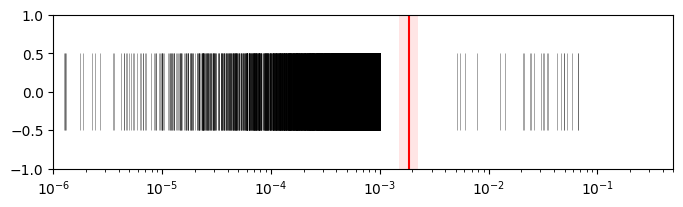

In [7]:
fig, ax = plt.subplots(figsize=(8,2))
ax.vlines(gen_evts,-0.5,0.5,color='black',lw=0.5, alpha=0.5)
ax.axvline(threshold,ls='-',color='red')
ax.axvspan(threshold-energy_res,threshold+energy_res,facecolor='red',alpha=0.1)

ax.set_yscale('linear')
ax.set_ylim(-1,1)

ax.set_xscale('log')
ax.set_xlim(1e-6,0.5)

## Reset and run the sens projection

In [8]:
SE.reset_sim()

SE.add_flat_bkgd(1) # flat background of 1 DRU
SE.add_nfold_lee_bkgd(m=n_devices,n=coinc,w=window)


On mass 1 of 1.
 Routine CnMax failed.
30.201459884643555
30.201459884643555

exposure was  1.0  kg-days
masses =  [0.5]
ULs =  [4.07983253e-39]
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.
 Routine CnMax failed.


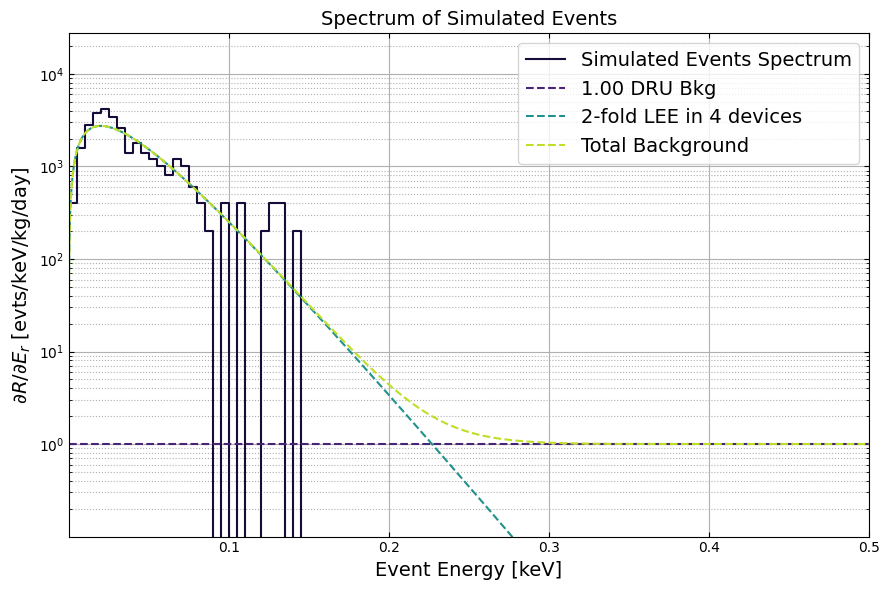

In [15]:
# run the simulation 

#m_dms=np.geomspace(0.1, 2, num=10)

m_dm, sig = SE.run_sim(
    threshold,
    0.5,
    e_low=1e-6,
    m_dms=np.array([0.5]),
    #m_dms=np.geomspace(0.01, 2, num=15),
    nexp=1, # increase for a better estimate, 1 is generally used for diagnostics
    npts=1000,
    plot_bkgd=True,
    res=energy_res,
    verbose=True,
    sigma0=1e-41
)

print('\nexposure was ',SE.exposure,' kg-days')
print('masses = ',m_dm)
print('ULs = ',sig)

Plot results

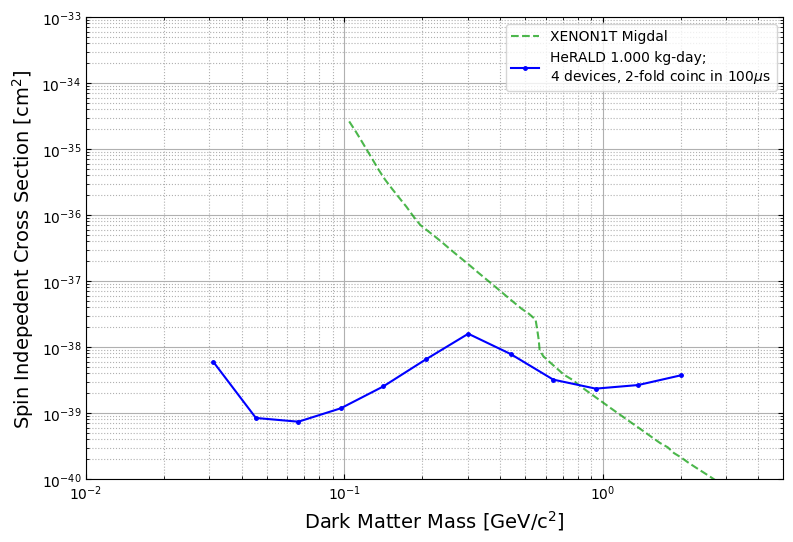

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))

x1tmig = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/XENON1T-Migdal.txt')
#cresst = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/CRESST.txt')

plt.plot(*(x1tmig.T),color=(0.,0.6,0.,0.7),ls='--',label='XENON1T Migdal')
#plt.plot(*(cresst.T),color=(0.8,0.1,0.1,0.7),label='CRESST')

lab = 'HeRALD {:0.3f} kg-day;\n{:d} devices, {:d}-fold coinc in {:0.0f}$\mu$s'.format(SE.exposure,n_devices,coinc,window/1e-6)
plt.plot(m_dm, sig, color='b',marker='.',ms=5,label=lab)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-40, 1e-33)
ax.set_xlim(0.01, 5)
ax.set_xlabel("Dark Matter Mass [GeV/c$^2$]", fontsize=14)
ax.set_ylabel("Spin Indepedent Cross Section [cm$^2$]", fontsize=14)
#ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

ax.legend(loc='upper right',frameon=True)

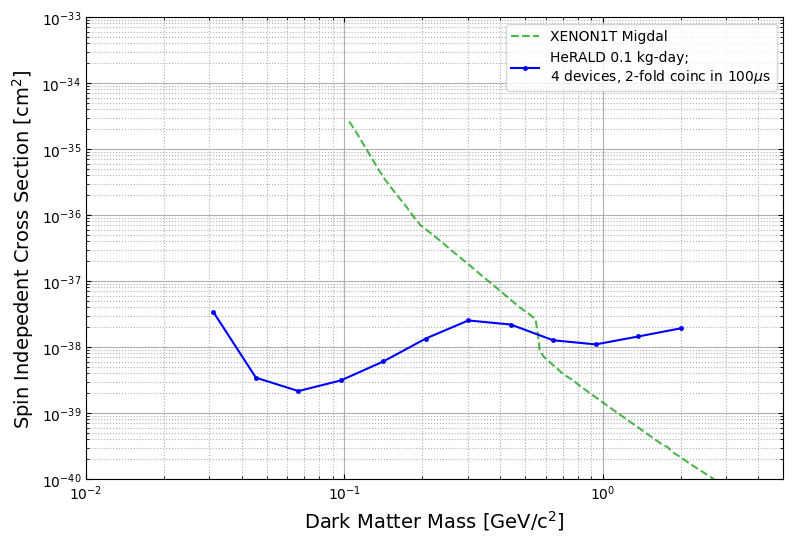

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))

x1tmig = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/XENON1T-Migdal.txt')
#cresst = np.loadtxt('/global/cfs/cdirs/lz/users/haselsco/TESSERACT_Limits/snowmass2021-wp-cf1-neutrinofloor/data/published/SI/CRESST.txt')

plt.plot(*(x1tmig.T),color=(0.,0.6,0.,0.7),ls='--',label='XENON1T Migdal')
#plt.plot(*(cresst.T),color=(0.8,0.1,0.1,0.7),label='CRESST')

lab = 'HeRALD {:0.1f} kg-day;\n{:d} devices, {:d}-fold coinc in {:0.0f}$\mu$s'.format(SE.exposure,n_devices,coinc,window/1e-6)
plt.plot(m_dm, sig, color='b',marker='.',ms=5,label=lab)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-40, 1e-33)
ax.set_xlim(0.01, 5)
ax.set_xlabel("Dark Matter Mass [GeV/c$^2$]", fontsize=14)
ax.set_ylabel("Spin Indepedent Cross Section [cm$^2$]", fontsize=14)
#ax.set_title("Estimated Sensitivity", fontsize=14)

ax.grid()
ax.grid(which="minor", linestyle='dotted')
ax.tick_params(which="both", direction="in", right=True, top=True)

ax.legend(loc='upper right',frameon=True)

In [16]:
# save results to txt file
outname = 'HeRALD_{:0.1f}kgday_{:d}device_{:d}fold_{:0.0f}mus.txt'.format(SE.exposure,n_devices,coinc,window/1e-6)

if False:
    tot = np.column_stack( (m_dm, sig) )
    np.savetxt(outname,tot,fmt=['%.5e','%0.5e'] ,delimiter=' ')

